In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from mpl_toolkits.mplot3d.art3d import Line3DCollection

import seaborn as sns
sns.set()
import numpy as np
import umap

from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_openml, fetch_lfw_people
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import pairwise_distances


from mpl_toolkits import mplot3d


In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

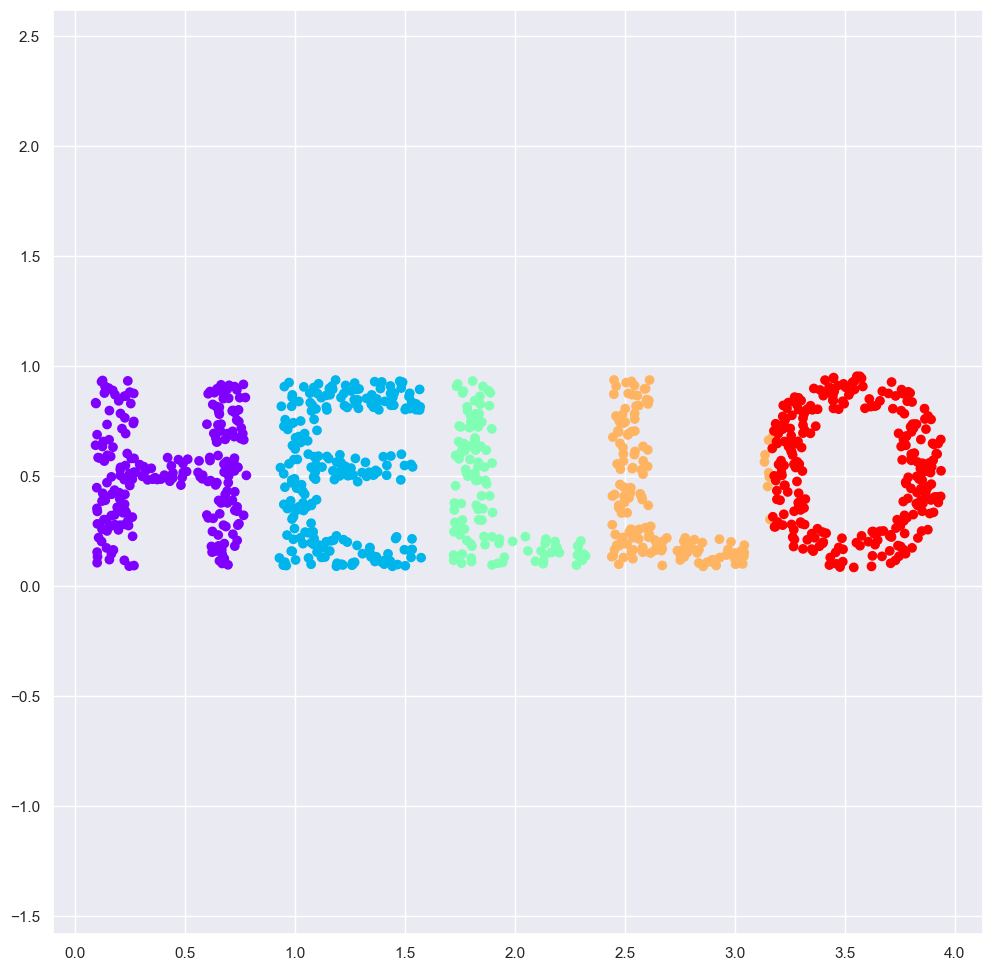

In [3]:
X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
fig=plt.figure(figsize=(12, 12))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

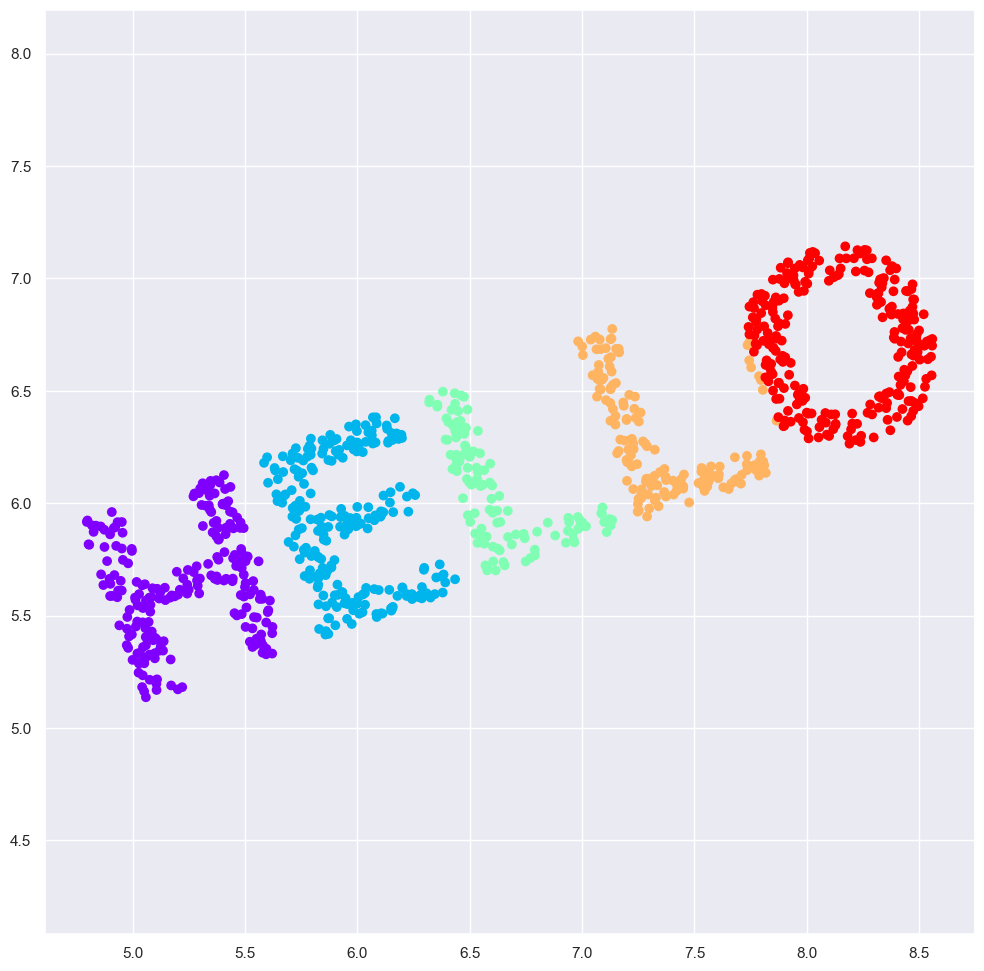

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
fig=plt.figure(figsize=(12, 12))
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

In [5]:
D = pairwise_distances(X)
D.shape

(1000, 1000)

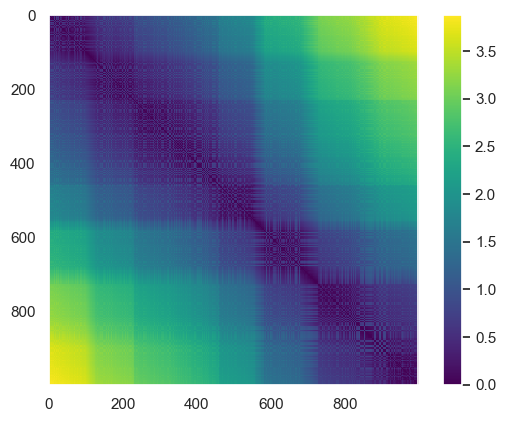

In [6]:
plt.imshow(D, zorder=2, cmap='viridis', interpolation='nearest')
plt.colorbar();

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

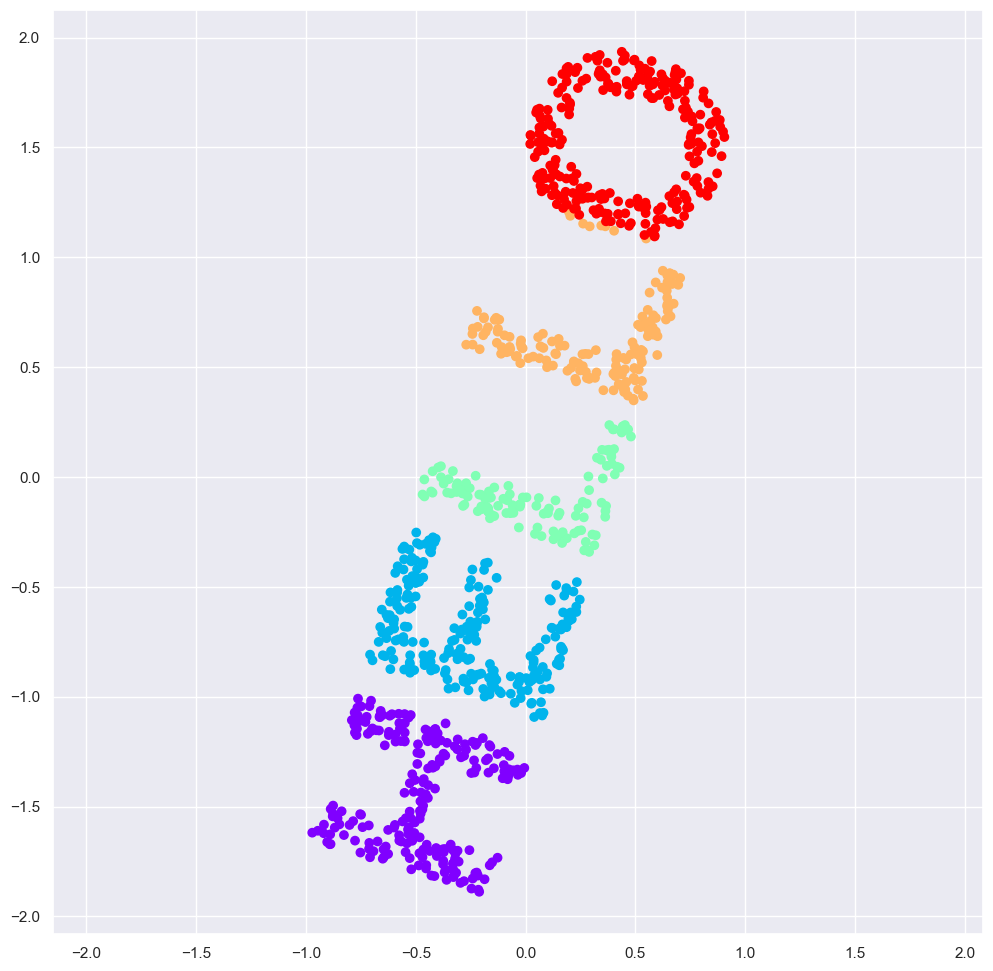

In [8]:
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
fig=plt.figure(figsize=(12, 12))
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

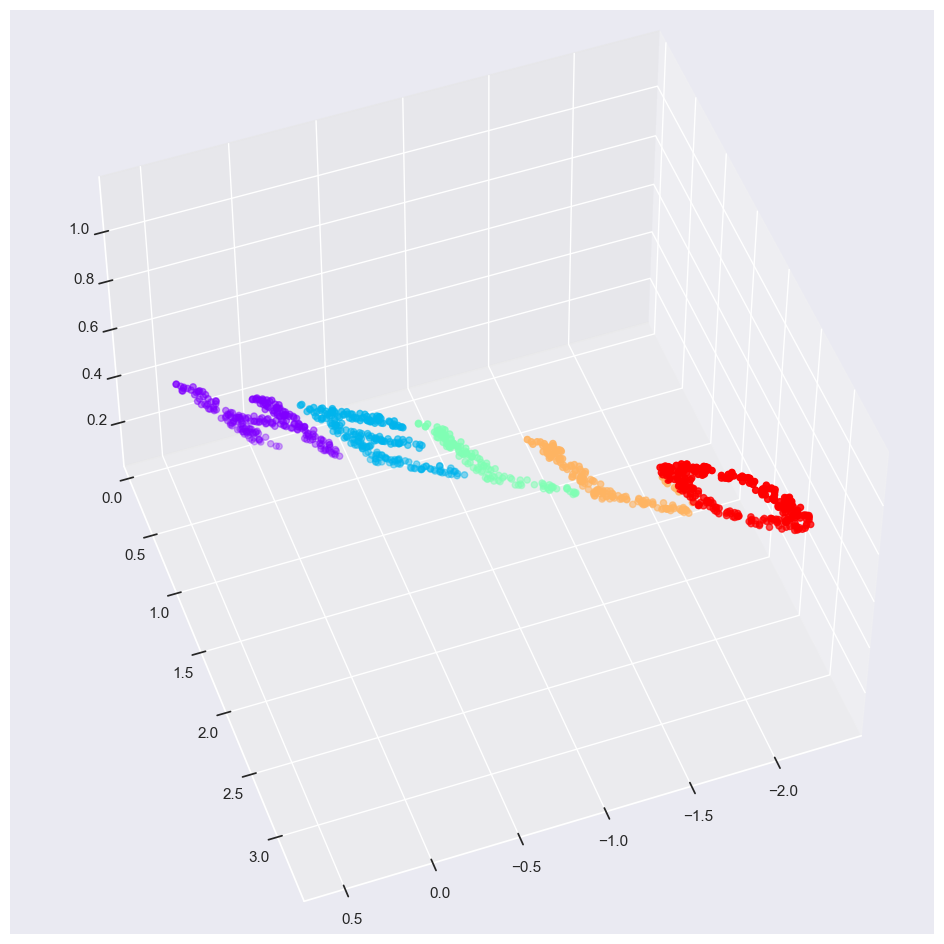

In [10]:
fig=plt.figure(figsize=(12, 12))

ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

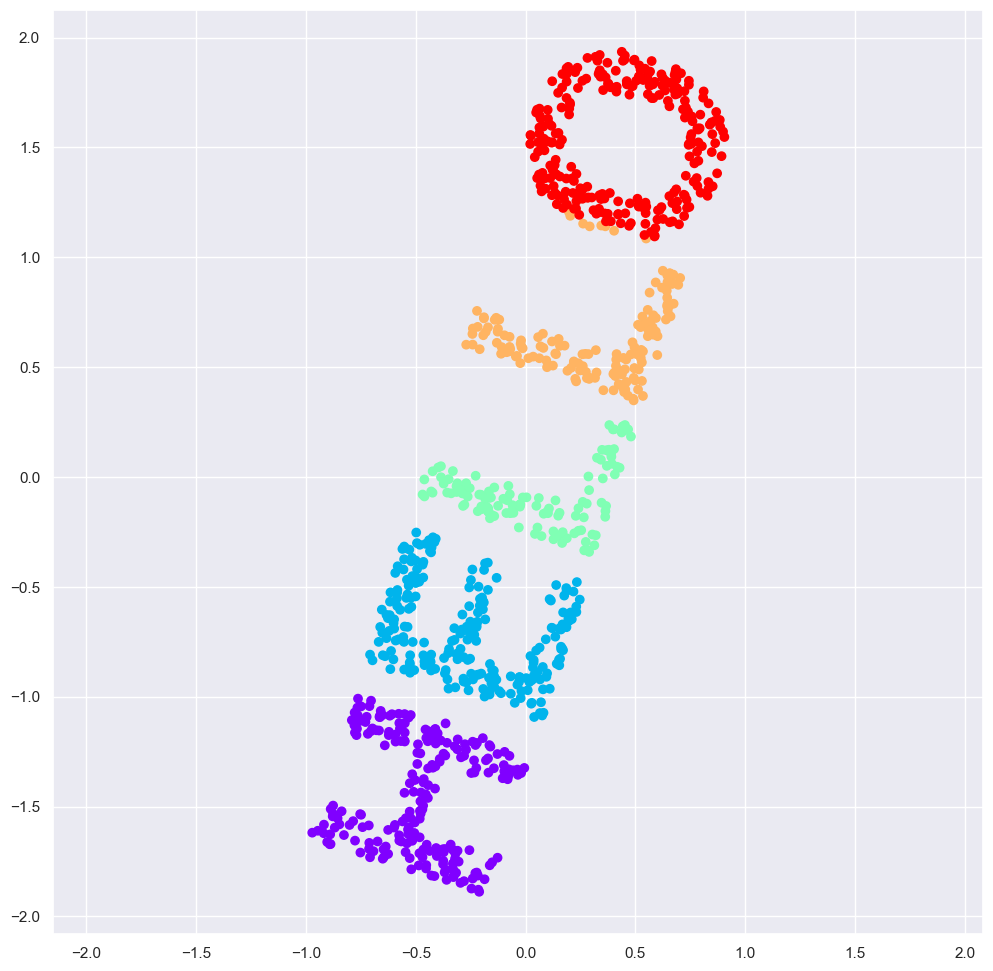

In [11]:
model = MDS(n_components=2, random_state=1)
fig=plt.figure(figsize=(12, 12))
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

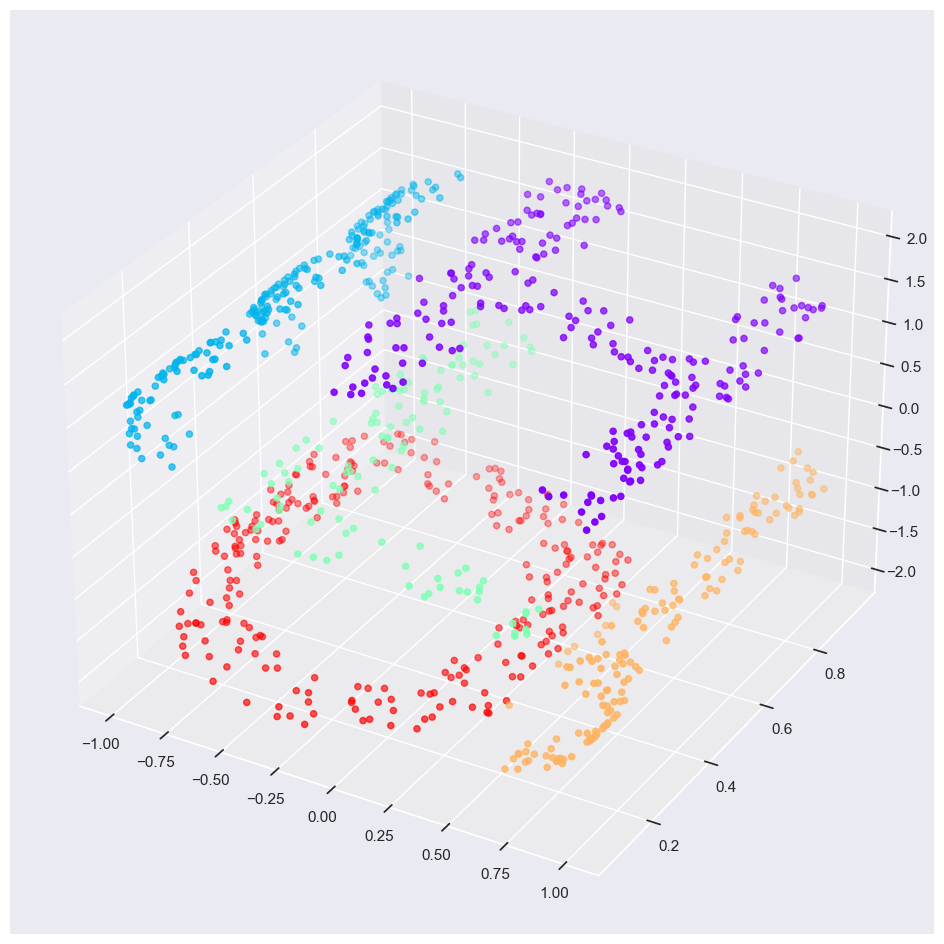

In [13]:
from mpl_toolkits import mplot3d
fig=plt.figure(figsize=(12, 12))

ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

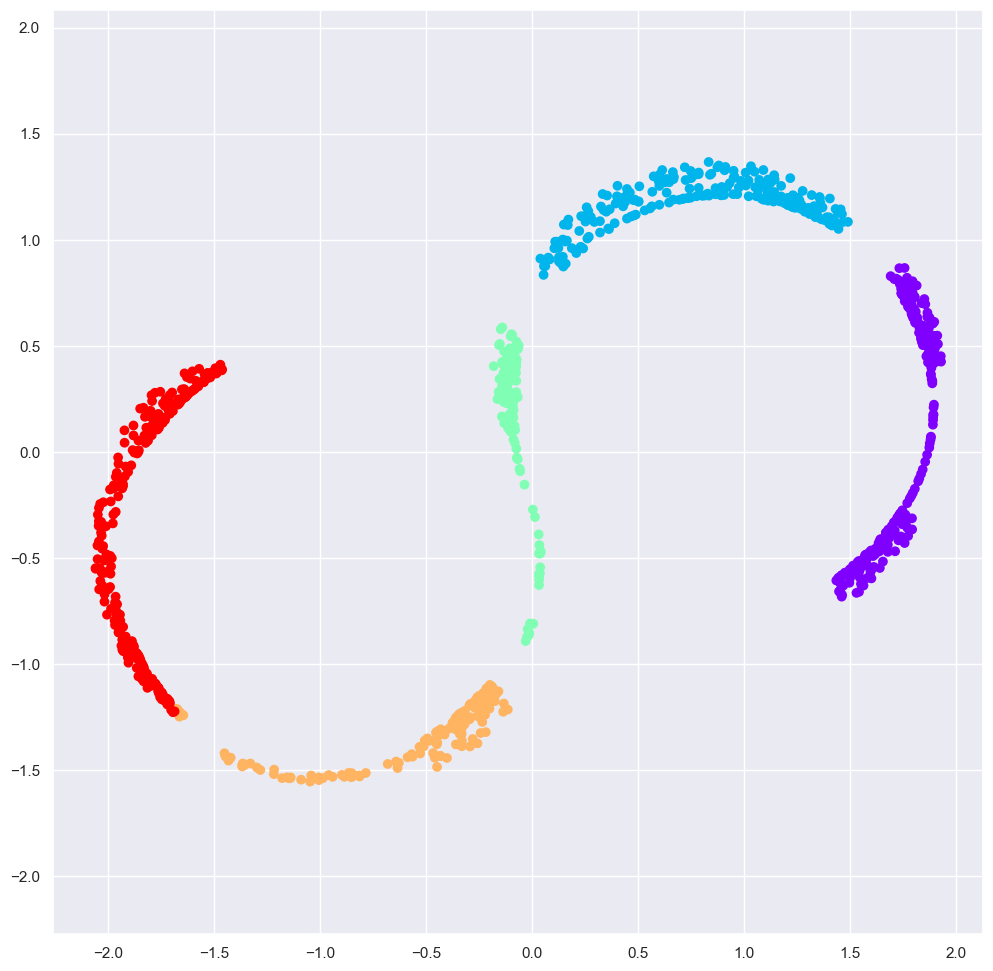

In [14]:
from sklearn.manifold import MDS
fig=plt.figure(figsize=(12, 12))

model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

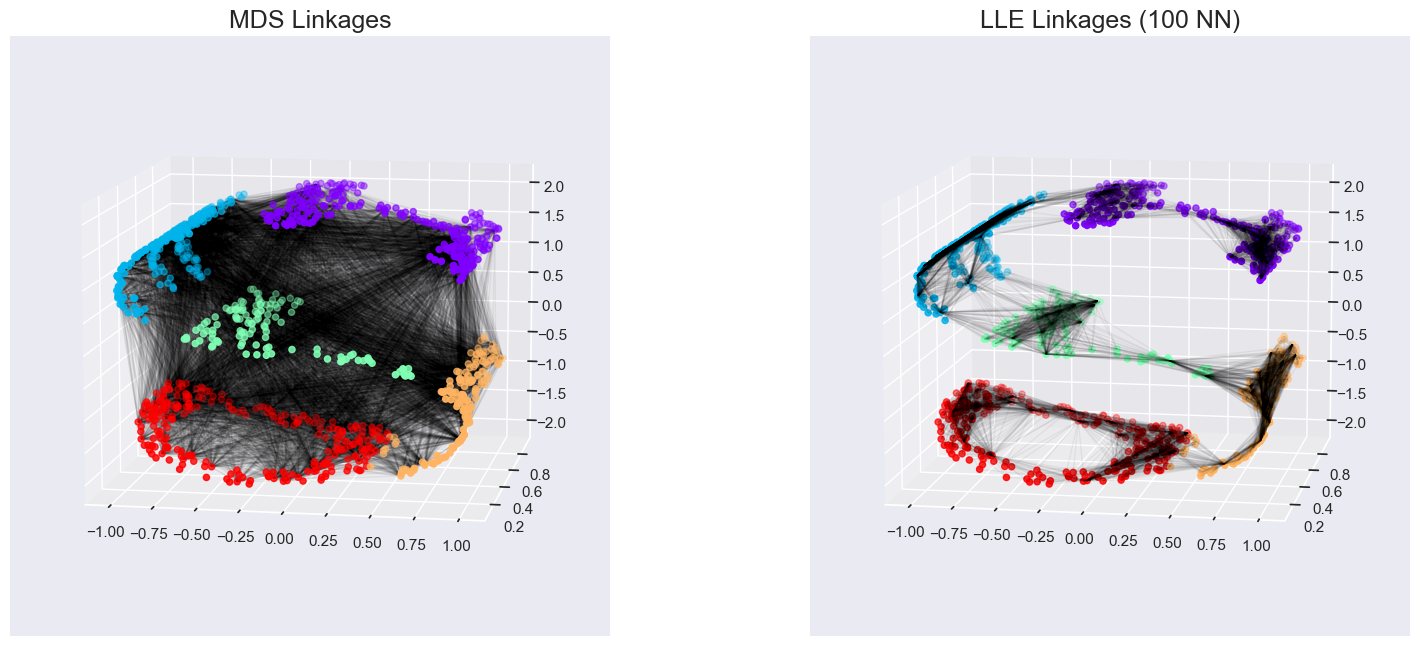

In [15]:


# construct lines for MDS
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
lines_MDS = [(XS[i], XS[j]) for i in ind[:100] for j in ind[100:200]]

# construct lines for LLE
nbrs = NearestNeighbors(n_neighbors=100).fit(XS).kneighbors(XS[ind[:100]])[1]
lines_LLE = [(XS[ind[i]], XS[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    axi.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2], **colorize);
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

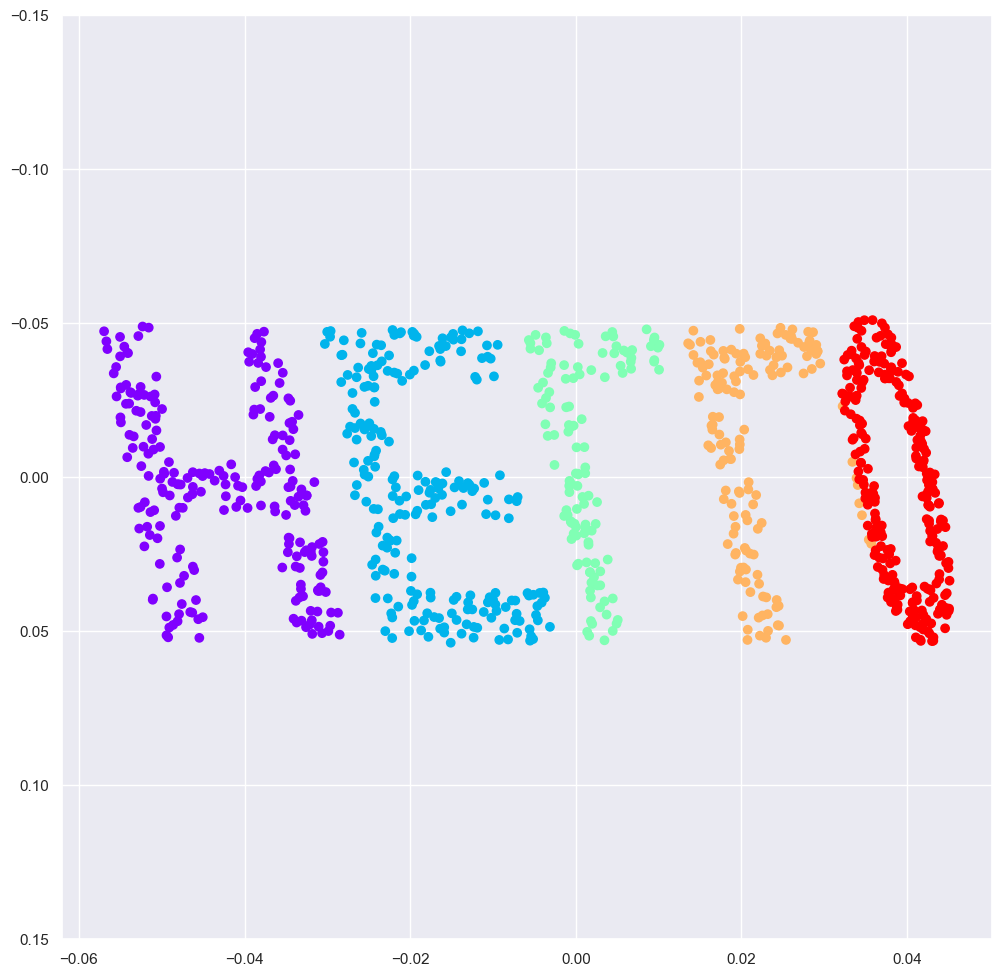

In [16]:

model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)


fig, ax = plt.subplots(figsize=(12,12))
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

In [17]:
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(2370, 2914)

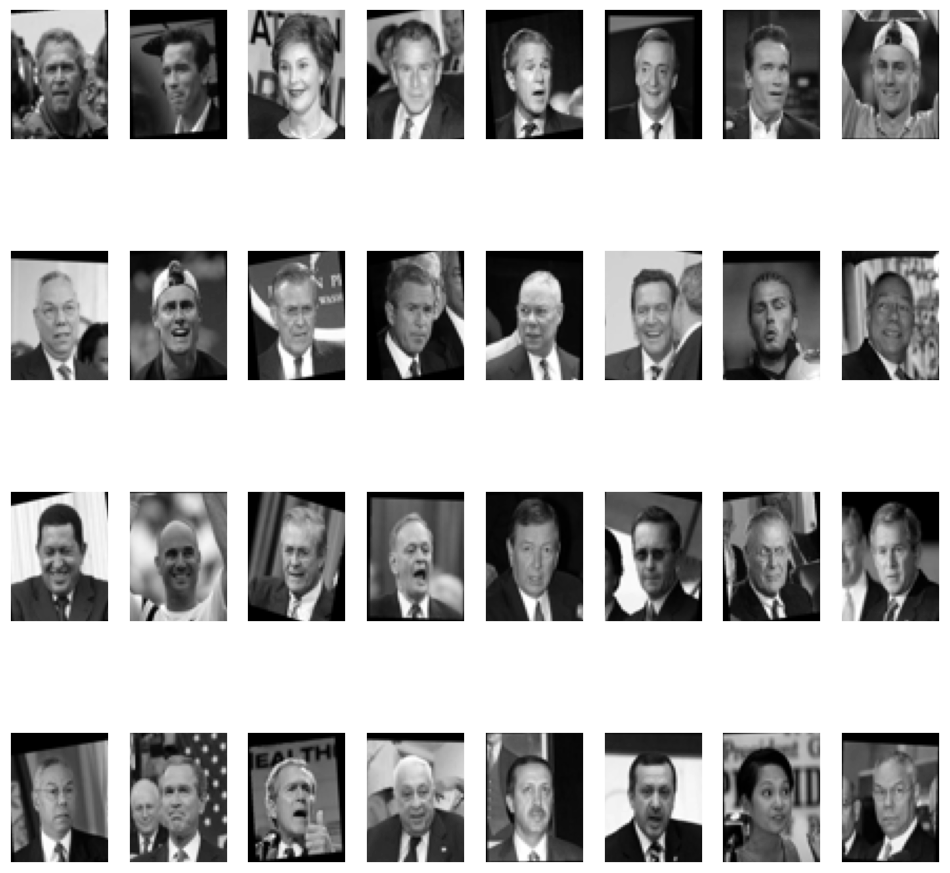

In [18]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]), figsize=(12,12))

for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

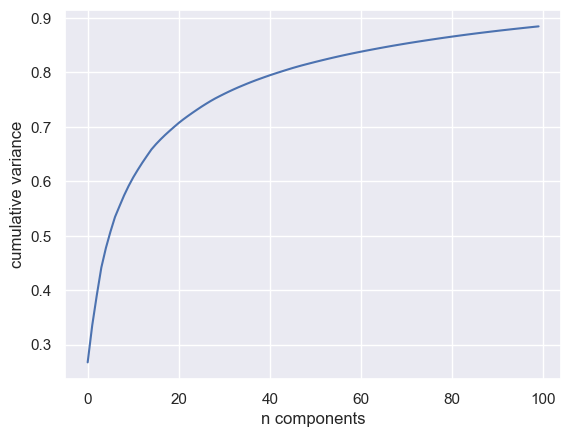

In [19]:

model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

In [20]:

model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(2370, 2)

In [21]:


def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

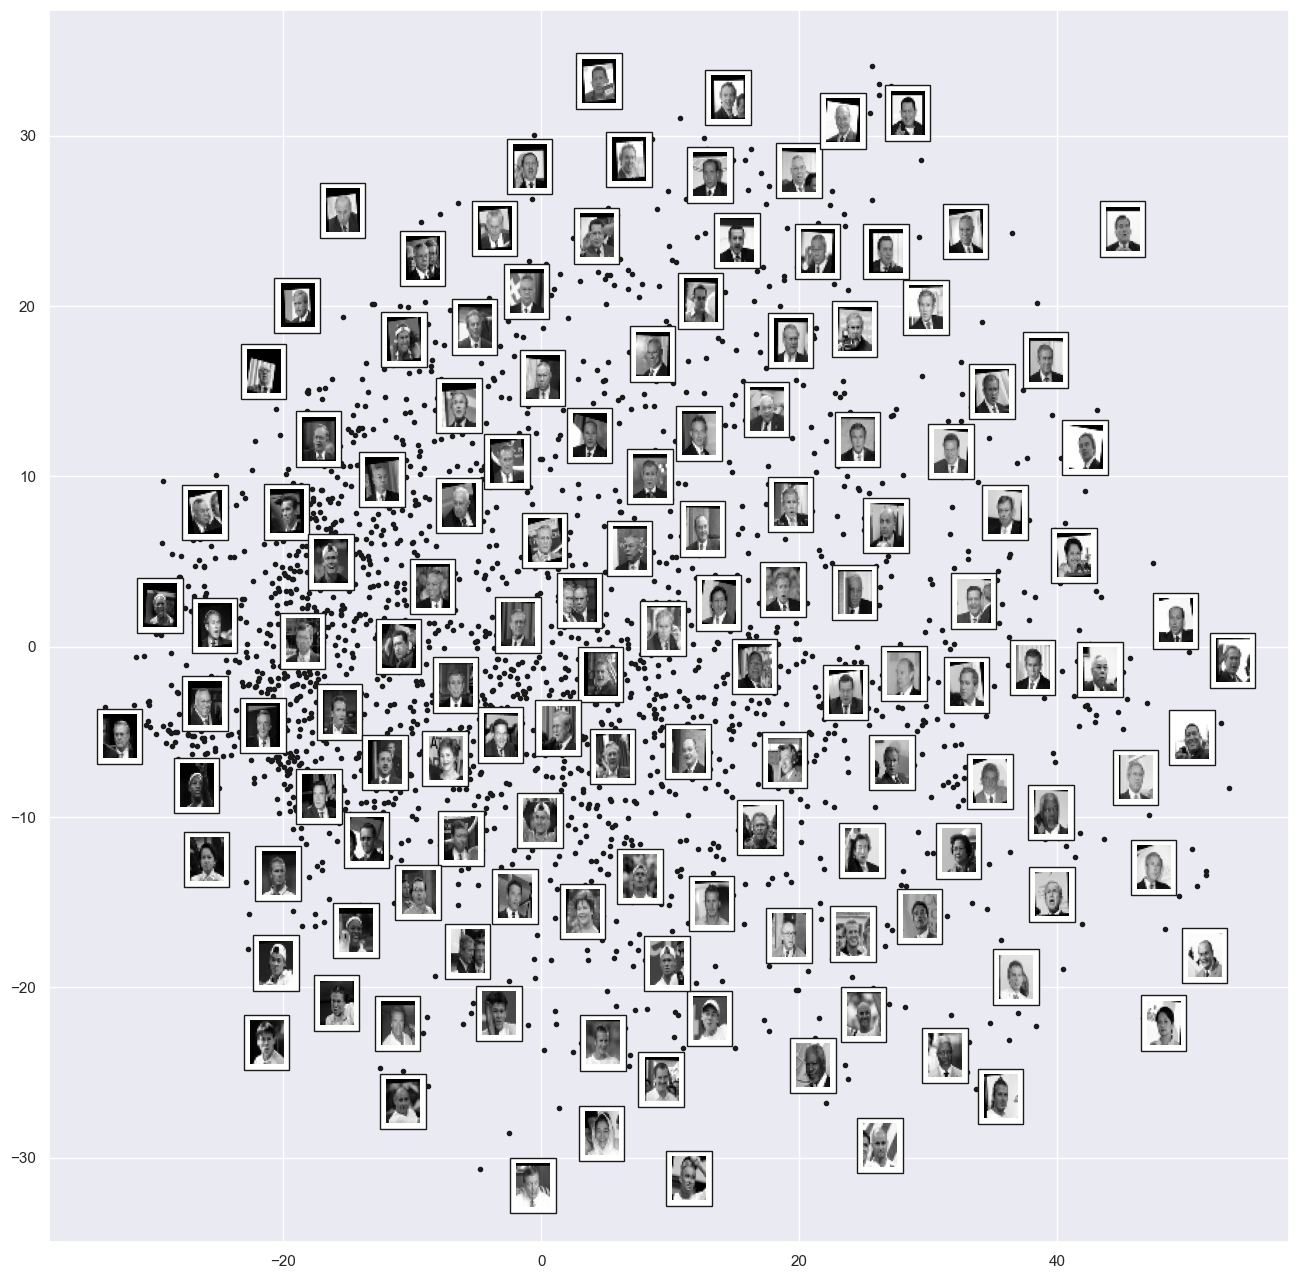

In [22]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

In [23]:

mnist = fetch_openml('mnist_784', version=1, cache=True)

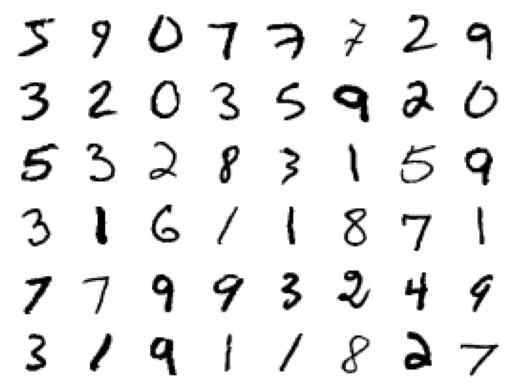

In [24]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data.loc[1250 * i].to_numpy().reshape(28, 28), cmap='gray_r')

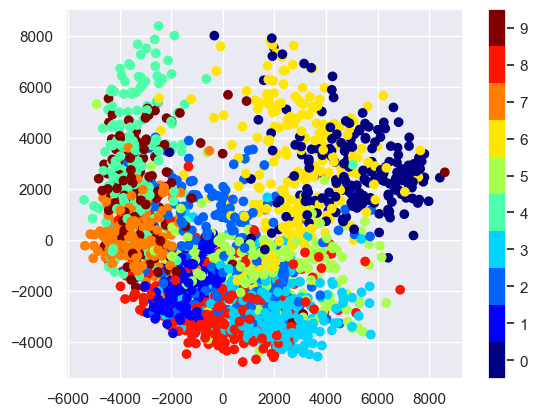

In [25]:


# use only 1/30 of the data: full dataset takes a long time!
data = mnist.data[::30]
target = mnist.target[::30].astype(int)

model = Isomap(n_components=2)
proj = model.fit_transform(data)
scaler = MinMaxScaler()
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet',10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

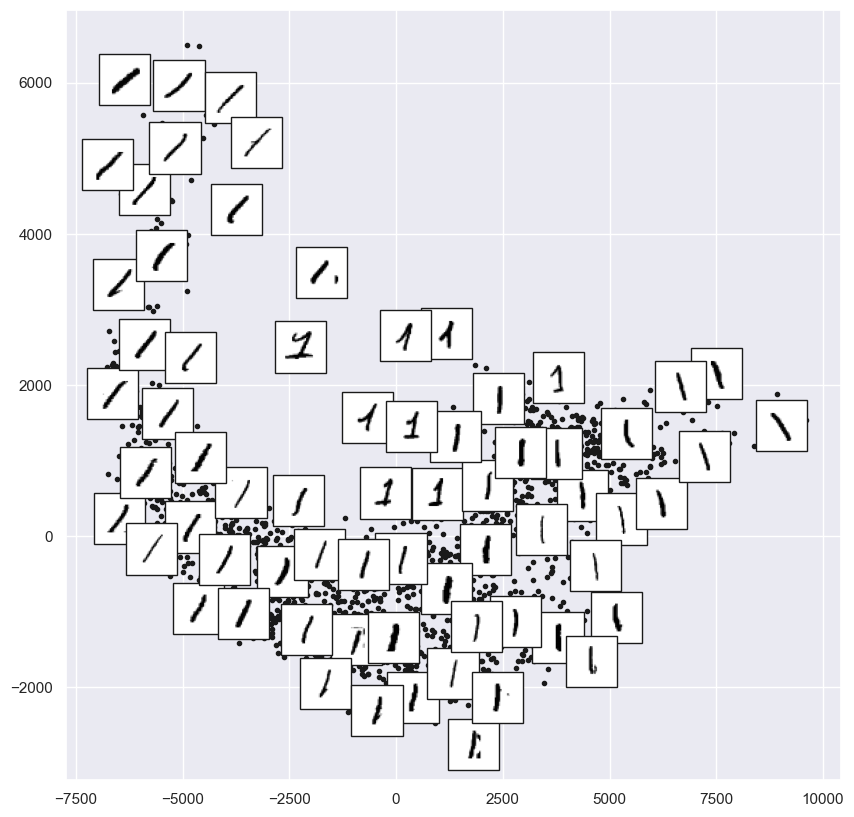

In [26]:
from sklearn.manifold import Isomap

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target.astype(int) == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.to_numpy().reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jca92\AppData\Roaming\Python\Python310\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


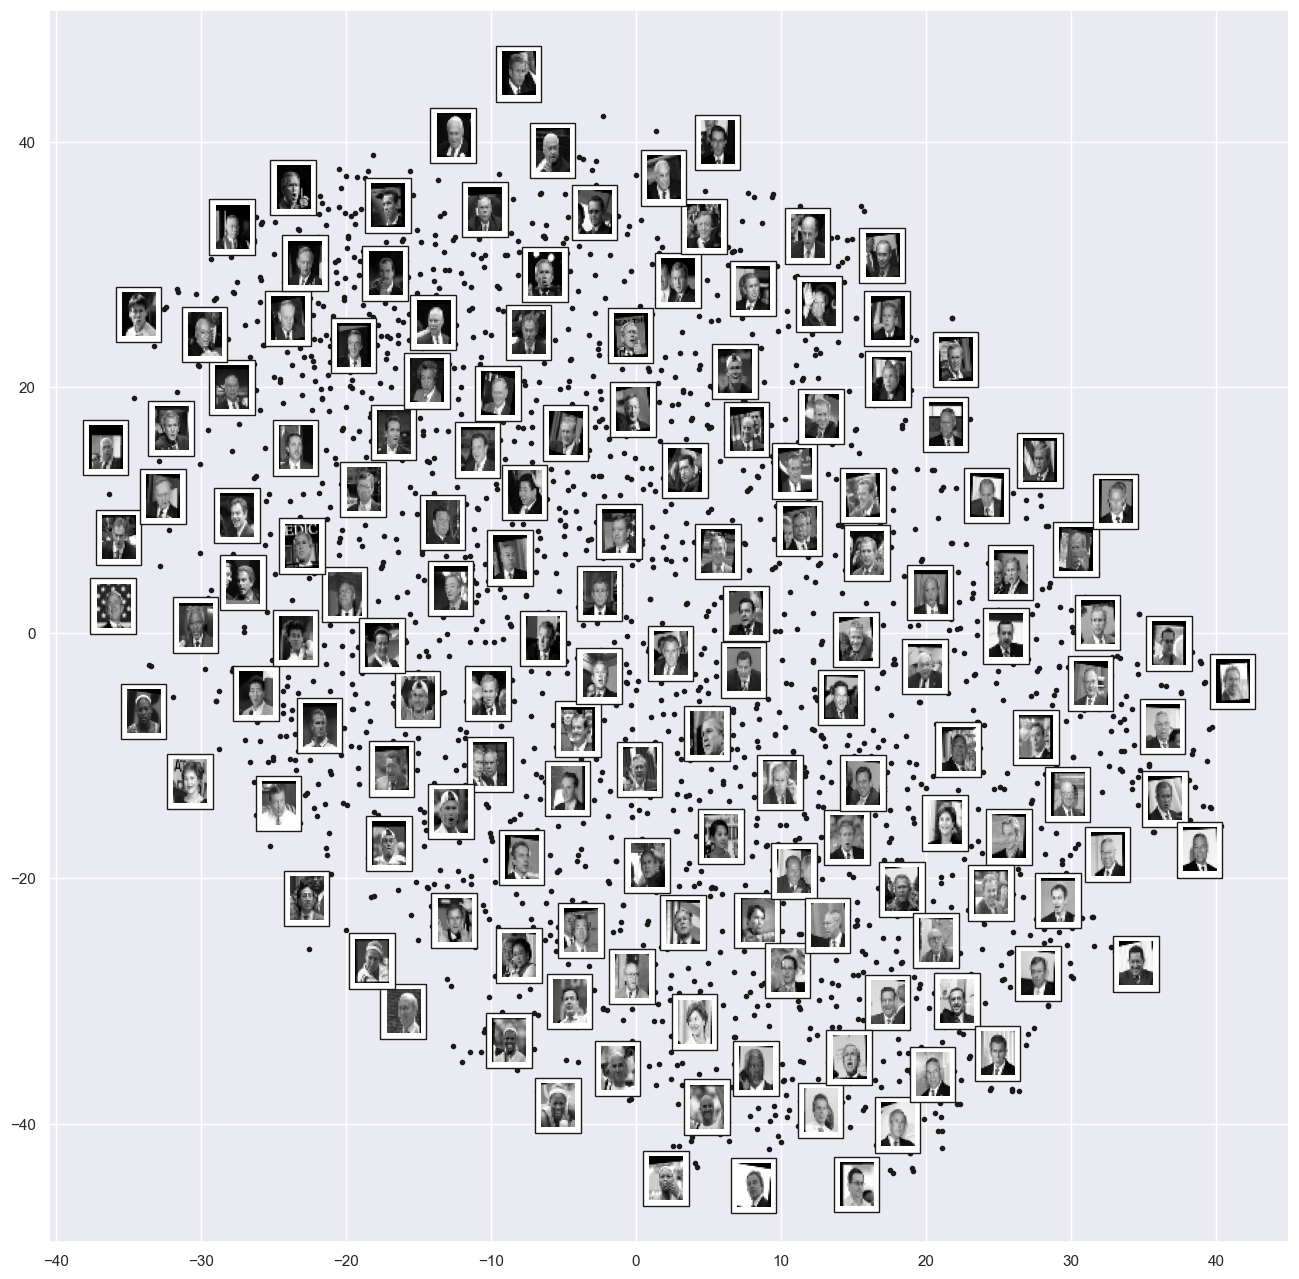

In [27]:
fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=TSNE(n_components=2),
                images=faces.images[:, ::2, ::2])

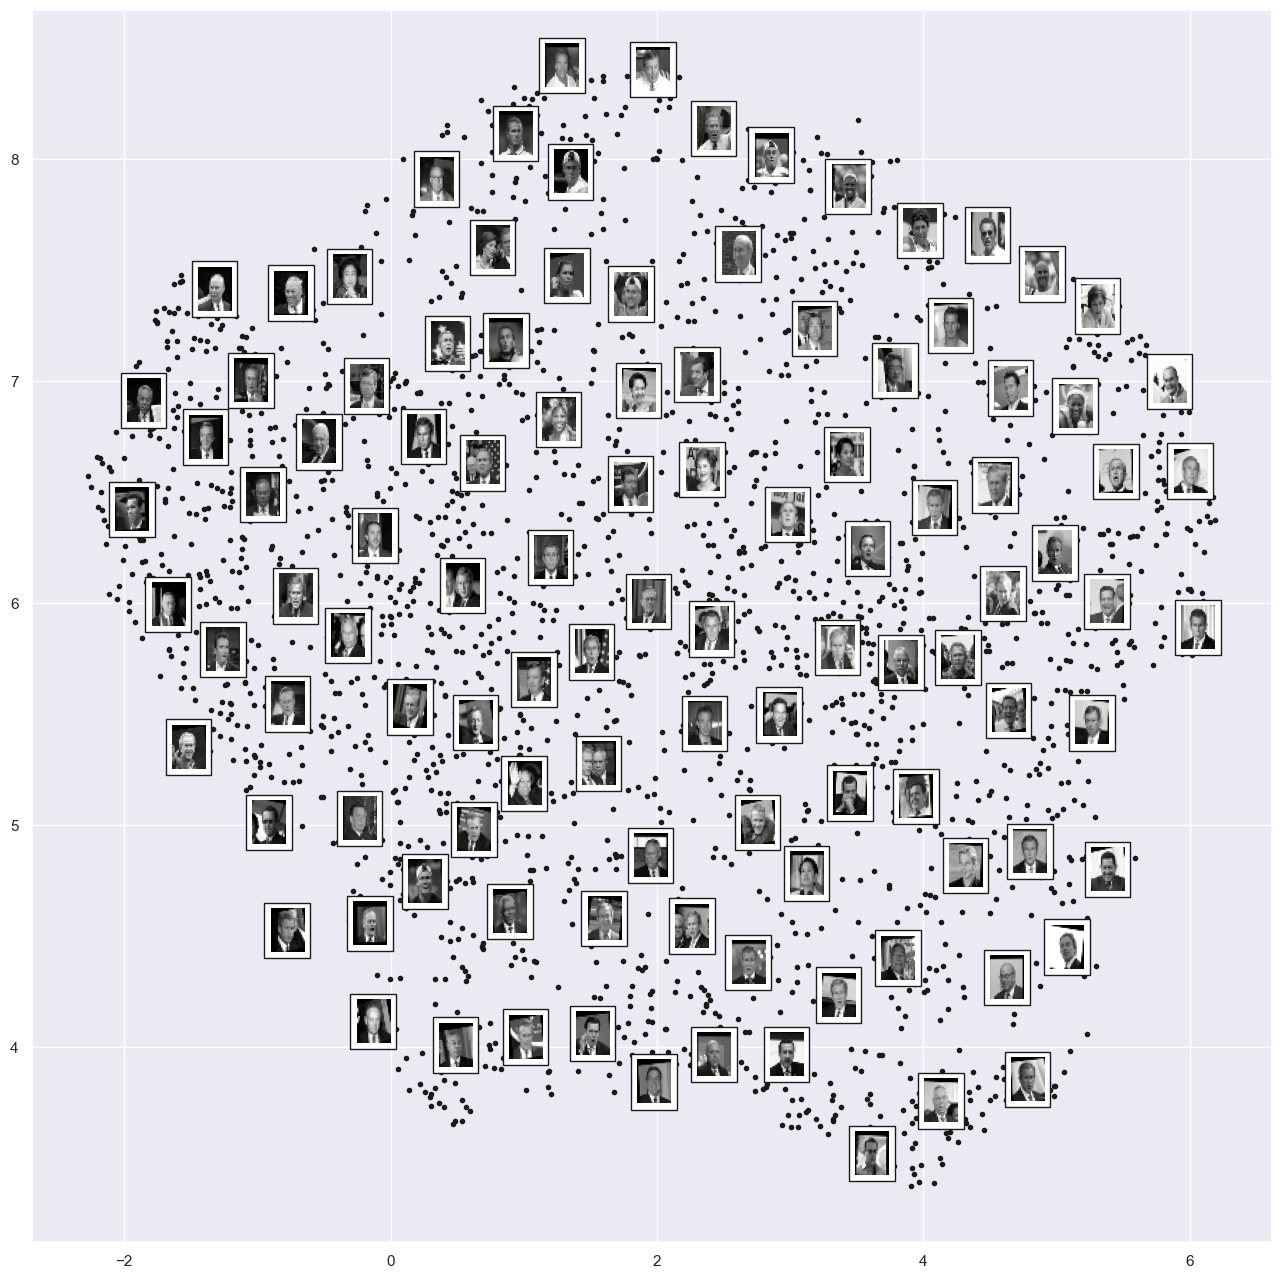

In [28]:
reducer = umap.UMAP

fig, ax = plt.subplots(figsize=(16, 16))
plot_components(faces.data,
                model=reducer(n_components=2),
                images=faces.images[:, ::2, ::2])

: 

: 